In [1]:
# Imports and Setup
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use Agg backend for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Ensure the plt module uses a proper backend if needed

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

%matplotlib inline

# Setting a seaborn style for better aesthetics
sns.set(style='whitegrid')

In [3]:
# Data Loading and Overview

# Load the smartphones dataset from the CSV file
df = pd.read_csv('/content/Smartphones_cleaned_dataset.csv', encoding='ascii', delimiter=',')

# Display basic information about the dataset
print('Dataset Shape:', df.shape)
print('Dataset Info:')
print(df.info())

# Display the first few rows
df.head()

Dataset Shape: (980, 26)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand_name                 980 non-null    object 
 1   model                      980 non-null    object 
 2   price                      980 non-null    int64  
 3   rating                     879 non-null    float64
 4   has_5g                     980 non-null    bool   
 5   has_nfc                    980 non-null    bool   
 6   has_ir_blaster             980 non-null    bool   
 7   processor_brand            960 non-null    object 
 8   num_cores                  974 non-null    float64
 9   processor_speed            938 non-null    float64
 10  battery_capacity           969 non-null    float64
 11  fast_charging_available    980 non-null    int64  
 12  fast_charging              769 non-null    float64
 13  ram_capacit

,brand_name,model,price,rating,has_5g,has_nfc,has_ir_blaster,processor_brand,num_cores,processor_speed,...,refresh_rate,num_rear_cameras,num_front_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,extended_upto,resolution_width,resolution_height
0,oneplus,OnePlus 11 5G,54999,89.0,True,True,False,snapdragon,8.0,3.2,...,120,3,1.0,android,50.0,16.0,0,NaN,1440,3216
1,oneplus,OnePlus Nord CE 2 Lite 5G,19989,81.0,True,False,False,snapdragon,8.0,2.2,...,120,3,1.0,android,64.0,16.0,1,1024.0,1080,2412
2,samsung,Samsung Galaxy A14 5G,16499,75.0,True,False,False,exynos,8.0,2.4,...,90,3,1.0,android,50.0,13.0,1,1024.0,1080,2408
3,motorola,Motorola Moto G62 5G,14999,81.0,True,False,False,snapdragon,8.0,2.2,...,120,3,1.0,android,50.0,16.0,1,1024.0,1080,2400
4,realme,Realme 10 Pro Plus,24999,82.0,True,False,False,dimensity,8.0,2.6,...,120,3,1.0,android,108.0,16.0,0,NaN,1080,2412


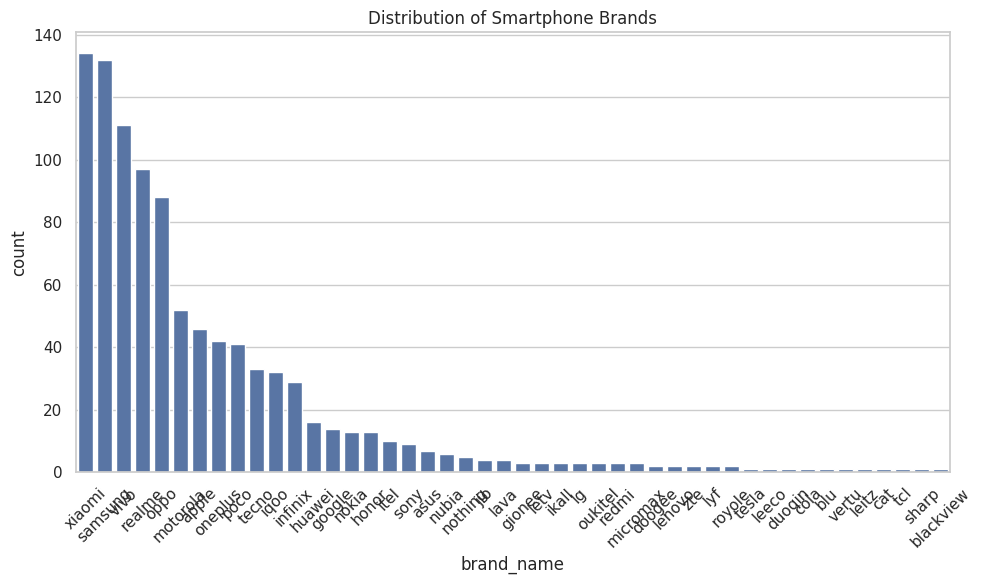

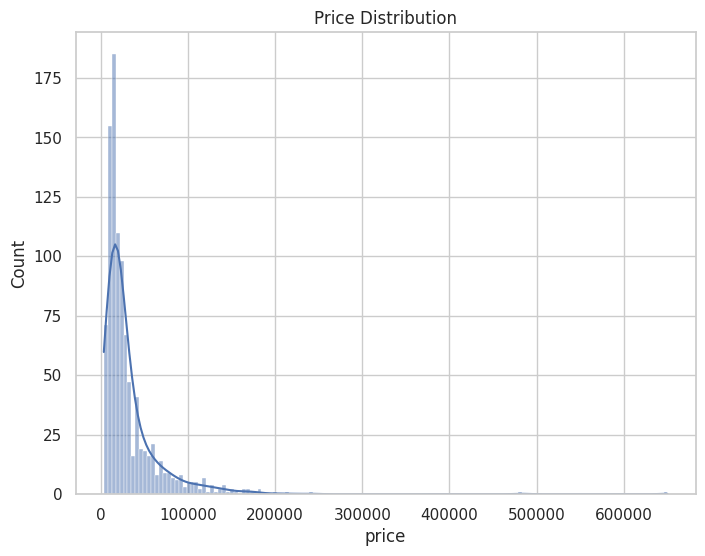

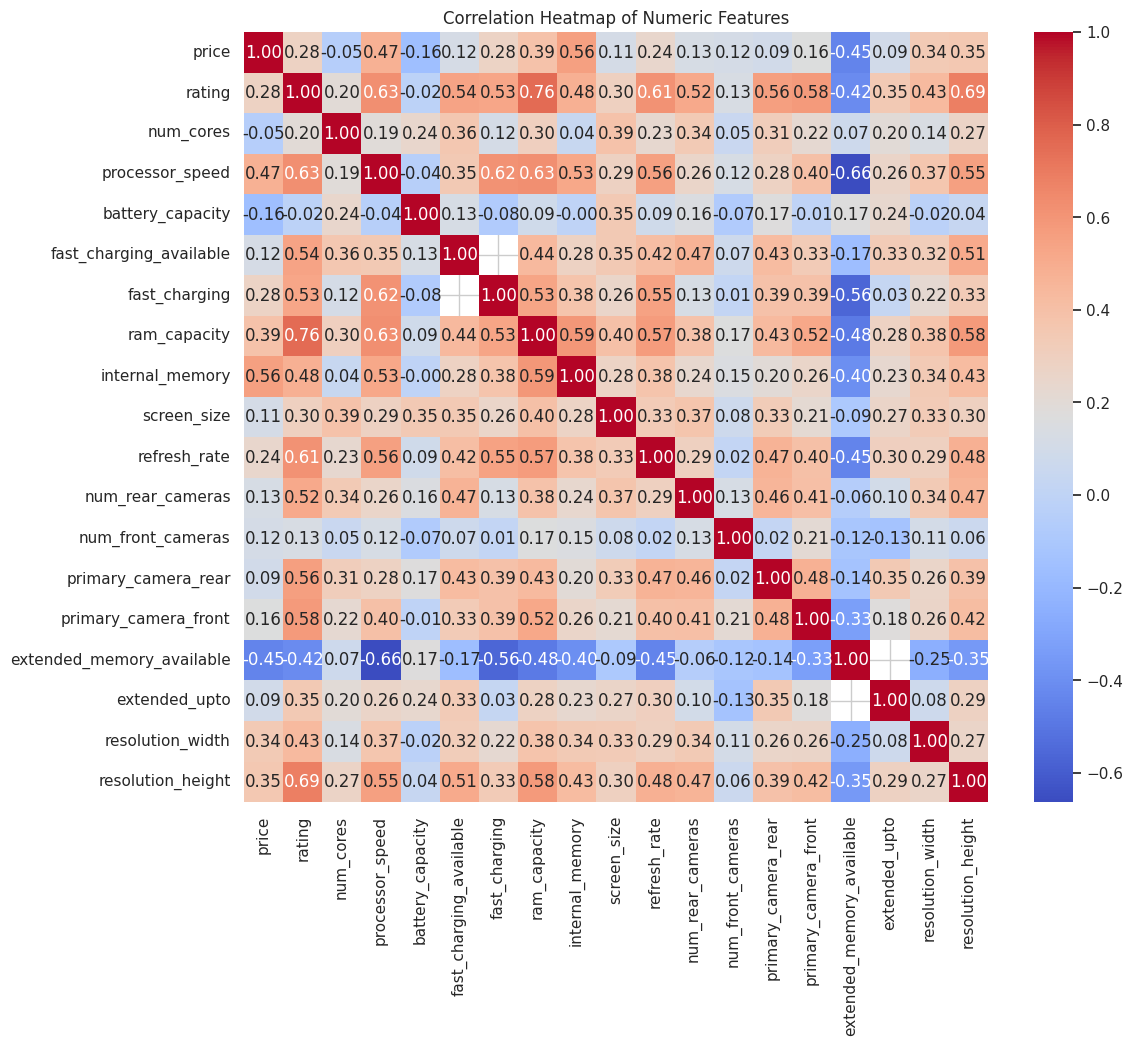

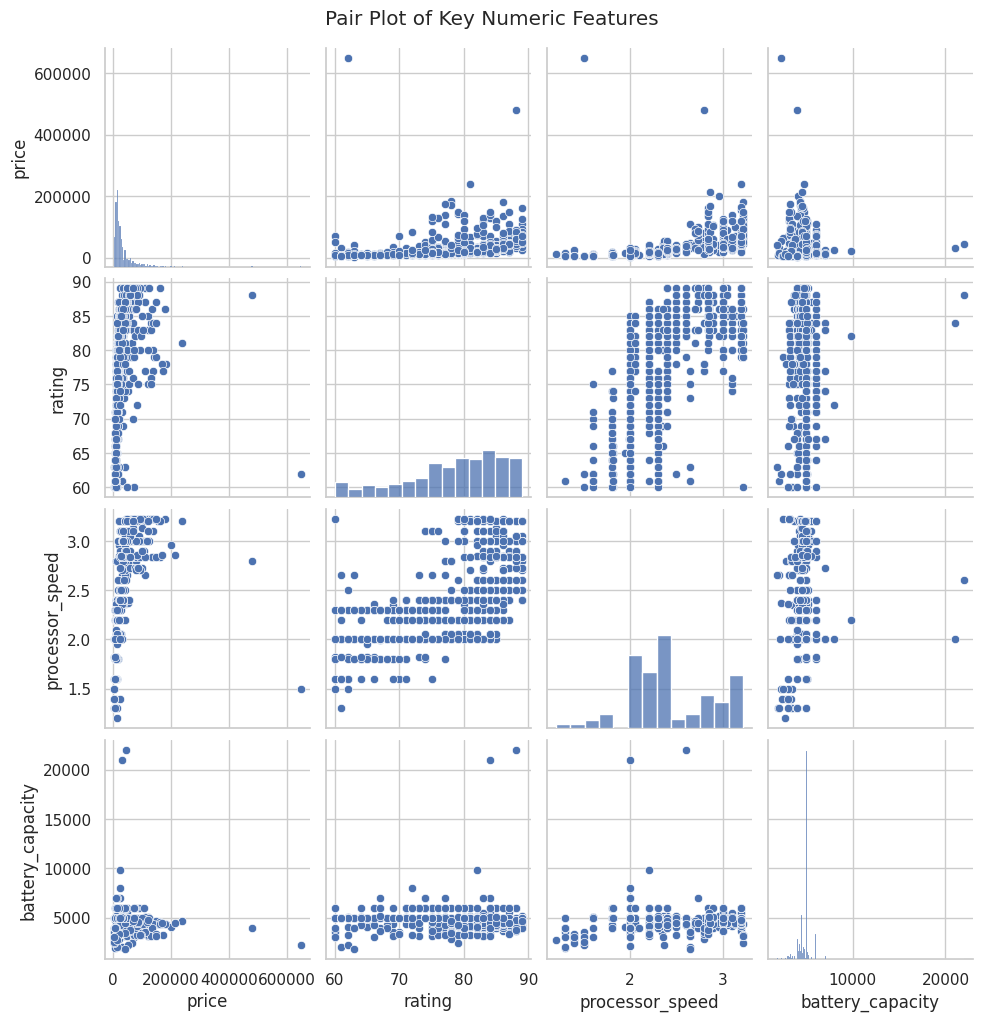

In [4]:
# Exploratory Data Analysis

# A quick look at the distribution of brands using a pie chart style count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='brand_name', order=df['brand_name'].value_counts().index)
plt.title('Distribution of Smartphone Brands')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot a histogram for the price distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='price', kde=True)
plt.title('Price Distribution')
plt.show()

# If there are four or more numeric columns, create a heatmap of correlations
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 10))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Create a pair plot for some key numeric features if desired
cols_for_pairplot = ['price', 'rating', 'processor_speed', 'battery_capacity']
if all(col in numeric_df.columns for col in cols_for_pairplot):
    sns.pairplot(df[cols_for_pairplot])
    plt.suptitle('Pair Plot of Key Numeric Features', y=1.02)
    plt.show()

In [5]:
# Data Cleaning and Preprocessing

# It appears that our data might contain missing values. Missing values can cause errors in modeling,
# as seen in previous attempts with LinearRegression. We will impute missing values appropriately.

# Create a copy of the original dataset for preprocessing
df_clean = df.copy()

# Identify column types
categorical_features = ['brand_name', 'os', 'processor_brand']
numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Exclude target and non modeling features from numeric_features
if 'price' in numeric_features:
    numeric_features.remove('price')
if 'model' in df_clean.columns:
    df_clean = df_clean.drop('model', axis=1)

# Handle missing values for numeric columns with median imputation
imputer_numeric = SimpleImputer(strategy='median')
df_clean[numeric_features] = imputer_numeric.fit_transform(df_clean[numeric_features])

# For categorical features, fill missing values with the mode (most frequent value)
for col in categorical_features:
    if df_clean[col].isnull().any():
        mode_value = df_clean[col].mode()[0]
        df_clean[col].fillna(mode_value, inplace=True)

# Verify that no missing values remain
print('Missing values per column after imputation:')
print(df_clean.isnull().sum())

# One-hot encode categorical features. We drop the first category to avoid multicollinearity.
df_model = pd.get_dummies(df_clean, columns=categorical_features, drop_first=True)

# Display the first few rows of the cleaned and preprocessed data
df_model.head()

Missing values per column after imputation:
brand_name                   0
price                        0
rating                       0
has_5g                       0
has_nfc                      0
has_ir_blaster               0
processor_brand              0
num_cores                    0
processor_speed              0
battery_capacity             0
fast_charging_available      0
fast_charging                0
ram_capacity                 0
internal_memory              0
screen_size                  0
refresh_rate                 0
num_rear_cameras             0
num_front_cameras            0
os                           0
primary_camera_rear          0
primary_camera_front         0
extended_memory_available    0
extended_upto                0
resolution_width             0
resolution_height            0
dtype: int64


,price,rating,has_5g,has_nfc,has_ir_blaster,num_cores,processor_speed,battery_capacity,fast_charging_available,fast_charging,...,processor_brand_fusion,processor_brand_google,processor_brand_helio,processor_brand_kirin,processor_brand_mediatek,processor_brand_sc9863a,processor_brand_snapdragon,processor_brand_spreadtrum,processor_brand_tiger,processor_brand_unisoc
0,54999,89.0,True,True,False,8.0,3.2,5000.0,1.0,100.0,...,False,False,False,False,False,False,True,False,False,False
1,19989,81.0,True,False,False,8.0,2.2,5000.0,1.0,33.0,...,False,False,False,False,False,False,True,False,False,False
2,16499,75.0,True,False,False,8.0,2.4,5000.0,1.0,15.0,...,False,False,False,False,False,False,False,False,False,False
3,14999,81.0,True,False,False,8.0,2.2,5000.0,1.0,33.0,...,False,False,False,False,False,False,True,False,False,False
4,24999,82.0,True,False,False,8.0,2.6,5000.0,1.0,67.0,...,False,False,False,False,False,False,False,False,False,False


R2 Score of the Random Forest Regressor model: 0.744


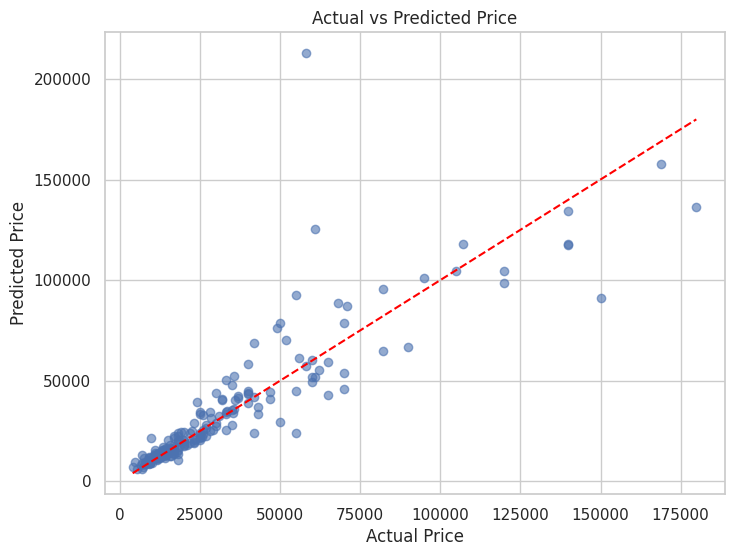

In [9]:
# Modeling: Random Forest Regression for Price Prediction

# Prepare the data for modeling
target = 'price'

# Identify features: include remaining numeric features from preprocessing
features = [col for col in df_model.columns if col != target]

# Define the independent variables X and dependent variable y
X = df_model[features]
y = df_model[target]

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using the R2 score
r2 = r2_score(y_test, y_pred)
print(f'R2 Score of the Random Forest Regressor model: {r2:.3f}')

# For further insight, plotting Actual vs Predicted prices.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()